In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Process the 20 Newsgroups Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

def parse_document(s):
    header, content = s.split('\n\n', 1)
    source, title, _ = header.split('\n', 2)
    return {'source': source.replace('From:', ''),
            'title': title.replace('Subject: ', ''),
            'content': content.strip()}

targets = {
 'comp.os.ms-windows.misc'  : 'Software',
 'comp.windows.x'           : 'Software',
 'comp.sys.ibm.pc.hardware' : 'Hardware',
 'comp.sys.mac.hardware'    : 'Hardware',
 'misc.forsale'             : 'For sale',
 'rec.autos'                : 'Autos',
 'rec.motorcycles'          : 'Autos',
 'rec.sport.baseball'       : 'Sports',
 'rec.sport.hockey'         : 'Sports',
 'sci.med'                  : 'Medicine',
 'sci.space'                : 'Space'
}

df = pd.DataFrame(list(map(parse_document, data.data)))
df['_id'] = np.arange(len(df)).astype('str')
df['group'] = [targets.get(x, 'None') for x in np.array(data.target_names)[data.target]]
df = df[df.group != 'None'].reset_index(drop=True)
df.head()

,content,source,title,_id,group
0,I was wondering if anyone out there could enli...,lerxst@wam.umd.edu (where's my thing),WHAT car is this!?,0,Autos
1,A fair number of brave souls who upgraded thei...,guykuo@carson.u.washington.edu (Guy Kuo),SI Clock Poll - Final Call,1,Hardware
2,"well folks, my mac plus finally gave up the gh...",twillis@ec.ecn.purdue.edu (Thomas E Willis),PB questions...,2,Hardware
3,"From article <C5owCB.n3p@world.std.com>, by to...",jcm@head-cfa.harvard.edu (Jonathan McDowell),Re: Shuttle Launch Question,4,Space
4,There were a few people who responded to my re...,bmdelane@quads.uchicago.edu (brian manning de...,Brain Tumor Treatment (thanks),6,Medicine


# Add text documents to database

In [3]:
from util import chissl_mongo as cm

cm.ChisslMongo()\
    .create_collection('Newsgroups', df.to_dict(orient='records'), drop=True)

# Build a text processing pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

import nltk
from nltk.stem.porter import PorterStemmer

class JSONTfidfVectorizer(TfidfVectorizer):
    def __init__(self, field='content', **kwargs):
        self.field = field
        self.stemmer = PorterStemmer()
        
        super().__init__(**kwargs,
                         preprocessor=self.extract,
                         tokenizer=self.stem
                        )
        
    def fit(self, X, y=None):
        self.stem_table = {}
        super().fit(X, y)
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def stem(self, text):
        return [self.stem_table.setdefault(self.stemmer.stem(item), item)
                for item in nltk.word_tokenize(text)
                if item.isalnum()]
        
    def extract(self, obj):
        return obj[self.field]
    
from umap import UMAP

pipe = Pipeline([
    ('tfidf', JSONTfidfVectorizer(stop_words='english', min_df=5, max_df=.2, sublinear_tf=True)),
    ('nmf', NMF(n_components=30)),
    ('norm', Normalizer('l1')),
    ('umap', UMAP(metric='cosine'))
])

cm.ChisslMongo()\
    .create_pipeline('TextPipeline', pipe, drop=True)

{'_id': 'TextPipeline',
 'pipeline': Binary(b'\x80\x03csklearn.pipeline\nPipeline\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00stepsq\x03]q\x04(X\x05\x00\x00\x00tfidfq\x05c__main__\nJSONTfidfVectorizer\nq\x06)\x81q\x07}q\x08(X\x05\x00\x00\x00fieldq\tX\x07\x00\x00\x00contentq\nX\x07\x00\x00\x00stemmerq\x0bcnltk.stem.porter\nPorterStemmer\nq\x0c)\x81q\r}q\x0e(X\x04\x00\x00\x00modeq\x0fX\x0f\x00\x00\x00NLTK_EXTENSIONSq\x10X\x04\x00\x00\x00poolq\x11}q\x12(X\x03\x00\x00\x00skyq\x13h\x13X\x05\x00\x00\x00skiesq\x14h\x13X\x05\x00\x00\x00dyingq\x15X\x03\x00\x00\x00dieq\x16X\x05\x00\x00\x00lyingq\x17X\x03\x00\x00\x00lieq\x18X\x05\x00\x00\x00tyingq\x19X\x03\x00\x00\x00tieq\x1aX\x04\x00\x00\x00newsq\x1bh\x1bX\x07\x00\x00\x00inningsq\x1cX\x06\x00\x00\x00inningq\x1dh\x1dh\x1dX\x07\x00\x00\x00outingsq\x1eX\x06\x00\x00\x00outingq\x1fh\x1fh\x1fX\x08\x00\x00\x00canningsq X\x07\x00\x00\x00canningq!h!h!X\x04\x00\x00\x00howeq"h"X\x07\x00\x00\x00proceedq#h#X\x06\x00\x00\x00exceedq$h$X\x07\x00\x00\x00succeedq%h%u

# Create a Newsgroups application

In [5]:
cm.ChisslMongo()\
    .create_application('20 Newsgroups (nmf)',
                        'Newsgroups',
                        'TextComponent',
                        'TextPipeline',
                        drop=True)

{'_id': '20 Newsgroups (nmf)',
 'collection': 'Newsgroups',
 'component': 'TextComponent',
 'pipeline': 'TextPipeline'}

# Fit a model

In [6]:
obj = cm.ChisslMongo(verbose=True)\
    .create_model('20 Newsgroups (nmf)',
                  'test',
                  project={'group': True}, drop=True)

Finding application <20 Newsgroups (nmf)>...OK
Finding pipeline <TextPipeline>...OK
Querying collection <Newsgroups>...found 6513...OK
Projecting data for histograms...OK
Transforming data...dropping...OK
done.


# Visualize results
We are looking for something with more structure than a big blob if it worked correctly

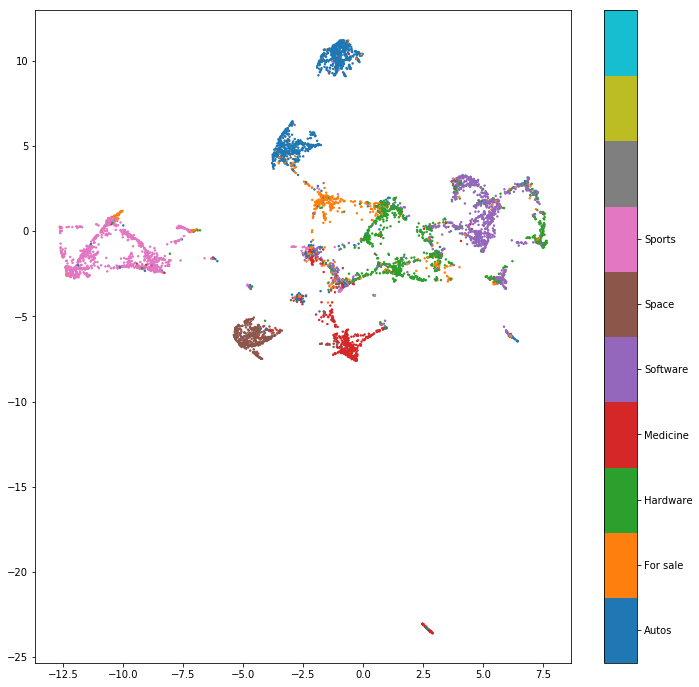

In [7]:
groups = obj['hist']['group']
groups_set = sorted(set(groups))
colors = {v: i for i, v in enumerate(groups_set)}

plt.figure(figsize=(12, 12))
plt.scatter(*np.array(obj['X']).T, s=2, c=list(map(colors.get, groups)), cmap='tab10', vmin=0, vmax=10);
cb = plt.colorbar()
cb.set_ticks(np.arange(len(groups_set)) + .5)
cb.set_ticklabels(groups_set)